In [ ]:
pip uninstall tensorflow tensorflow-tensorboard tensorflow-estimator

Uninstalling tensorflow-2.4.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.1
Uninstalling tensorflow-estimator-2.4.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/tensorflow_estimator-2.4.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow_estimator/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-estimator-2.4.0


In [ ]:
pip install -q tensorflow==2.4.1

In [ ]:
pip install -q tensorflow-quantum

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
a, b = sympy.symbols('a b')

q0, q1 = cirq.GridQubit.rect(1, 2)
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1))

cirq_simulator = cirq.Simulator()
z0 = cirq.Z(q0)

In [34]:
# Calculate a state vector with a=0.5 and b=-0.5.
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state_vector
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

In [35]:
z0 = cirq.Z(q0)

qubit_map={q0: 0, q1: 1}

z0.expectation_from_state_vector(output_state_vector, qubit_map).real

0.8775825500488281

In [36]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_state_vector(output_state_vector, qubit_map).real

-0.04063427448272705

In [37]:
# Rank 1 tensor containing 1 circuit.
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [38]:
# Rank 1 tensor containing 2 Pauli operators.
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape

TensorShape([2])

In [39]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=np.float32)

In [40]:
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state_vector = cirq_simulator.simulate(circuit, resolver).final_state_vector
    cirq_results.append(
        [z0.expectation_from_state_vector(final_state_vector, {
            q0: 0,
            q1: 1
        }).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[-0.53097433]
 [ 0.78233898]
 [ 0.95369607]
 [-0.29804471]
 [ 0.98929858]]


In [41]:
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.53097314],
       [ 0.7823404 ],
       [ 0.9536959 ],
       [-0.29804528],
       [ 0.9892987 ]], dtype=float32)>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


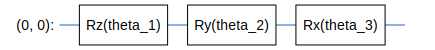

In [42]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

In [43]:
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [44]:
controller(tf.constant([[0.0],[1.0]])).numpy()

array([[ 0.        ,  0.        ,  0.        ],
       [-0.20311671, -0.02262558,  0.34340566]], dtype=float32)

In [45]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')


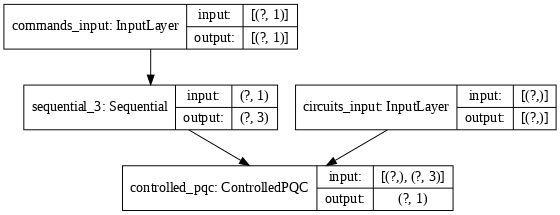

In [46]:
# Dense layer for the controller and command input
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit, operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [47]:
 # The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

# Miscalibrating the quantum circuit and making one copy for each data point (n=2)
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(cirq.rx(random_rotations[0])(qubit), cirq.ry(random_rotations[1])(qubit), cirq.rz(random_rotations[2])(qubit))
datapoint_circuits = tfq.convert_to_tensor([noisy_preparation] * 2)  # Make two copied of this circuit

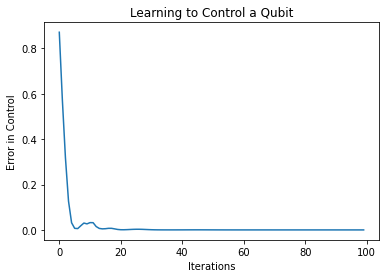

In [48]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=100,
                    verbose=0)

plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()


In [49]:
def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state
    expectation = z0.expectation_from_wavefunction(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expectation}\n')


check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [-0.7255831 -3.4756422 -1.3078411]
Which gives an actual expectation of: 0.9996427297592163

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-0.88595074 -0.67417926  1.2077612 ]
Which gives an actual expectation of: -0.9980844259262085



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: StateVectorTrialResult.final_state was used but is deprecated.
It will be removed in cirq v0.10.0.
Use final_state_vector instead.

  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: PauliString.expectation_from_wavefunction was used but is deprecated.
It will be removed in cirq v0.10.0.
Use expectation_from_state_vector instead

  


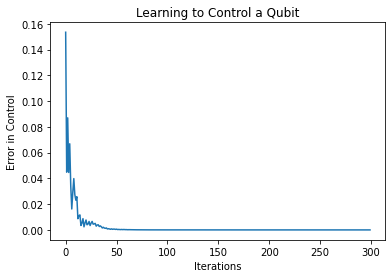

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [-1.2123588 -3.704764  -0.6897689]
Which gives an actual expectation of: 0.998417854309082

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-0.35098147 -2.6797318   2.2813156 ]
Which gives an actual expectation of: -0.9972876906394958

For a desired output (expectation) of [0.5] with noisy preparation, the controller
network found the following values for theta: [ 0.26117843 -1.1708856   4.9540863 ]
Which gives an actual expectation of: 0.5001158714294434

For a desired output (expectation) of [-0.5] with noisy preparation, the controller
network found the following values for theta: [0.7141029  0.46855634 7.403164  ]
Which gives an actual expectation of: -0.49994009733200073



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: StateVectorTrialResult.final_state was used but is deprecated.
It will be removed in cirq v0.10.0.
Use final_state_vector instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: PauliString.expectation_from_wavefunction was used but is deprecated.
It will be removed in cirq v0.10.0.
Use expectation_from_state_vector instead



In [50]:

# The command input values to the classical NN.
commands = np.array([[0], [1], [2], [3]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1], [.5], [-0.5]], dtype=np.float32)

random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit))

datapoint_circuits = tfq.convert_to_tensor([noisy_preparation] * 4)  # Make four copied of this circuit

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=300,
                    verbose=0)

plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in range(4):
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state
    expectation = z0.expectation_from_wavefunction(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expectation}\n')


check_error(commands, expected_outputs)